## <font color='blue'> ASTR 21100</font>

## <font color='blue'> Homework Assignment 6</font>
    
 
## <font color='blue'> 20 points</font>
   
### <font color='blue'> Distributed: Friday, February 9</font>

### <font color='blue'> Due: Thursday, February 15, 10pm</font>


### <font color='blue'>Introduction</font> 

In this homework you will practice application of function approximation methods of univariate functions to carry out commonly encountered analysis tasks: detrending of light curves (exercise 1), approximating empirically reconstructed function and evaluating its integral (exercise 2, in which you will use stellar mass function of galaxies to estimate the mean density of matter in stars in the Universe) and using spline approximation to generate random numbers that follow a distribution for which we do not have an equation and for which we do not have an equation for inverse cdf (exercise 3, in which you will generate a mock sample of SDSS galaxies that follow the stellar mass function of real galaxies). 

An extra-credit option is available upon request. It will involve implementation of a class to do Spline interpolation with capability to compute approximations for derivatives and integral of the approximated function. 


Import NumPy and Matplotlib and set Matplotlib defaults to produce nicer plots. 

In [1]:
import numpy as np 

# use jupyter "magic" command to tell it to embed plot into the notebook 
import matplotlib.pyplot as plt
%matplotlib inline

# the following code make plots look better
def plot_prettier(dpi=150, fontsize=11, usetex=False): 
    '''
    Make plots look nicer compared to Matplotlib defaults
    Parameters: 
        dpi - int, "dots per inch" - controls resolution of PNG images that are produced
                by Matplotlib
        fontsize - int, font size to use overall
        usetex - bool, whether to use LaTeX to render fonds of axes labels 
                use False if you don't have LaTeX installed on your system
    '''
    plt.rcParams['figure.dpi']= dpi
    plt.rc("savefig", dpi=dpi)
    plt.rc('font', size=fontsize)
    plt.rc('xtick', direction='in') 
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=5) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=5) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [2., 2.])
    if usetex:
        plt.rc('text', usetex=usetex)
    else:
        plt.rcParams['mathtext.fontset'] = 'cm'
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

plot_prettier()

### <font color='blue'>Exercise 1: A realistic example: de-trending a light curve of a star</font>


<img width=1000 src="https://github.com/dwkim78/pdtrend/blob/master/pdtrend/datasets/images/PDT_logo.png?raw=true"></img>




***Background.*** Brightness of many astronomical sources varies. In observations apparent (observed) brightness is measured as apparent magnitude $m$ that are related to energy flux in a given wavelength range $f$ as: $m=-2.5\log_{10}f + {\rm const}$, where ${\rm const}$ is a normalizing constant that defines *magnitude system*. 

Change of $m$ as a function of time for a source with a significantly varying brightness is called *lightcurve*. Lightcurves of variable stars is used to learn about physics of interior of these stars. In binary stars, occultations by one star of another which is reflected as a change of brightness of the system, lightcurves can be used to deduce orbital properties of the binary stars. Planets in some exoplanetary systems around some stars that are favorably oriented can block stars of the primary star in the system, which manifests as dips in the lightcurves of such stars. Detections of such dips was one of the main methods of finding exoplanets. 

When lightcurves are measured they are often subject to observational biases induced by instruments and real long-term changes of an object that are not related to the changes on short time scales such as dips. It is often useful or even required to remove such long term trends before searching for changes on short time scales. Such removal is called ***detrending***. 

<img width=600 src="https://github.com/dwkim78/pdtrend/blob/master/pdtrend/datasets/images/PDT_logo.png?raw=true"></img>


In this exercise, you have to come up with an approximation function to detrend a lightcurve. 

Code below downloads a set of lightcurves from the study of [Kim et al. 2009](https://ui.adsabs.harvard.edu/abs/2009MNRAS.397..558K/abstract). It shows how to select one lightcurve and plot it as a scatter plot (points). 

**Task 1a (3 points).** Decide which approximation method would be good to use to approximate the average trend in brightness measurements (think about whether it makes sense to use polynomial or spline approximation here and regression vs interpolation). Test your choice using the lightcurve using x and y vectors defined below. Overplot your approximation over points using `plt.plot`

**Task 1b (2 points).** Make a separate plot showing detrended flux, defined as original flux - approximation. Make sure that the detrended plot does not show long term trends seen in the original plot. In other words, the points should scatter around zero with no discernible large-scale trend over index ranges >300-500.

**Task 1c (1 point).** Plot the detrended brightnesses for the first 2000 time indices - describe what you see in the flux variation. 

***Note:*** examples of successful detrending are shown in the bottom panels of Figures 7 and 8 of [Kim et al. 2009](https://ui.adsabs.harvard.edu/abs/2009MNRAS.397..558K/abstract) where this data was published. 

In [2]:
"""
Base IO code for all datasets

from package pdtrend https://github.com/dwkim78/pdtrend
"""

import sys

from os.path import dirname
from os.path import join


def load_lightcurve_set():
    """
    Return the set of light curves for testing pdtrend.
    Returns
    -------
    lcs : numpy.ndarray
        An array of light curves.
    """

    import bz2
    try:
        import cPickle as pickle
    except:
        import pickle
    import urllib.request

    # The light curves are bzipped and pickled.
    #file_path = 'data/lc.pbz2'
    file_path = 'http://astro.uchicago.edu/~andrey/classes/a211/data/lc.pbz2'
    # For Python 3.
    if sys.version_info.major >= 3:
        #lcs = pickle.load(bz2.BZ2File(file_path, 'r'), encoding='bytes')
        lcs = pickle.load(bz2.BZ2File(urllib.request.urlopen(file_path)), encoding='bytes')

    # For Python 2.
    else:
        lcs = pickle.load(bz2.BZ2File(file_path, 'r'))

    return lcs

In [3]:
# load lightcurves (in arbitrary units)
lcs = load_lightcurve_set()

# generate index of the time variable from 0 to the length of lightcurves
times = np.ones(lcs.shape) * np.arange(lcs.shape[1])

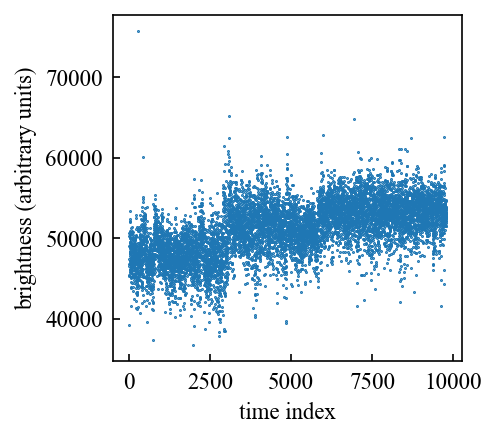

In [4]:
# select lightcurve number ilc (this can be index between 0 and 56)
ilc = 1
x, y = times[ilc], lcs[ilc]

# plot lightcurve as a scatter plot
plt.figure(figsize=(3,3))
plt.xlabel('time index'); plt.ylabel('brightness (arbitrary units)')
plt.scatter(times[1], lcs[1], s=0.2)
plt.show()

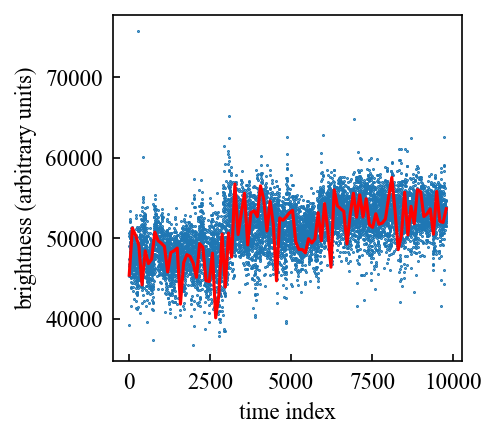

In [5]:
#polynomial and spline --> univariate functions
#examples in the 07 notebook
#use scipy and numpy

from scipy.interpolate import UnivariateSpline

# select lightcurve number ilc (this can be index between 0 and 56)
ilc = 1
x, y = times[ilc], lcs[ilc]

spl = UnivariateSpline(x, y, s=10.)
tg = np.linspace(times[1].min(), times[1].max(), 100)
ftest = spl(tg)




# plot lightcurve as a scatter plot
plt.figure(figsize=(3,3))
plt.xlabel('time index'); plt.ylabel('brightness (arbitrary units)')
plt.scatter(times[1], lcs[1], s=0.2)
plt.plot(tg,ftest, color = 'red')
plt.show()


You can use x and y defined above for regression. 

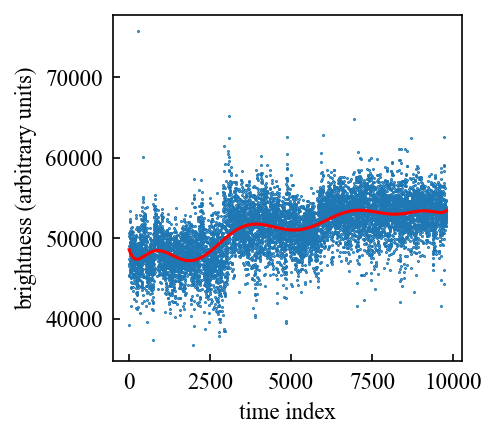

In [6]:
#polynomial and spline --> univariate functions
#examples in the 07 notebook
#use scipy and numpy

from scipy.interpolate import UnivariateSpline

# select lightcurve number ilc (this can be index between 0 and 56)
ilc = 1
x, y = times[ilc], lcs[ilc]


tg = np.linspace(times[1].min(), times[1].max(), 1000)
polyfit = np.polyfit(x, y, 10)
pfit = np.poly1d(polyfit) 
ftest = pfit(tg)



# plot lightcurve as a scatter plot
plt.figure(figsize=(3,3))
plt.xlabel('time index'); plt.ylabel('brightness (arbitrary units)')
plt.scatter(times[1], lcs[1], s=0.2)
plt.plot(tg,ftest, color = 'red')
plt.show()


Text(0, 0.5, 'detrended flux')

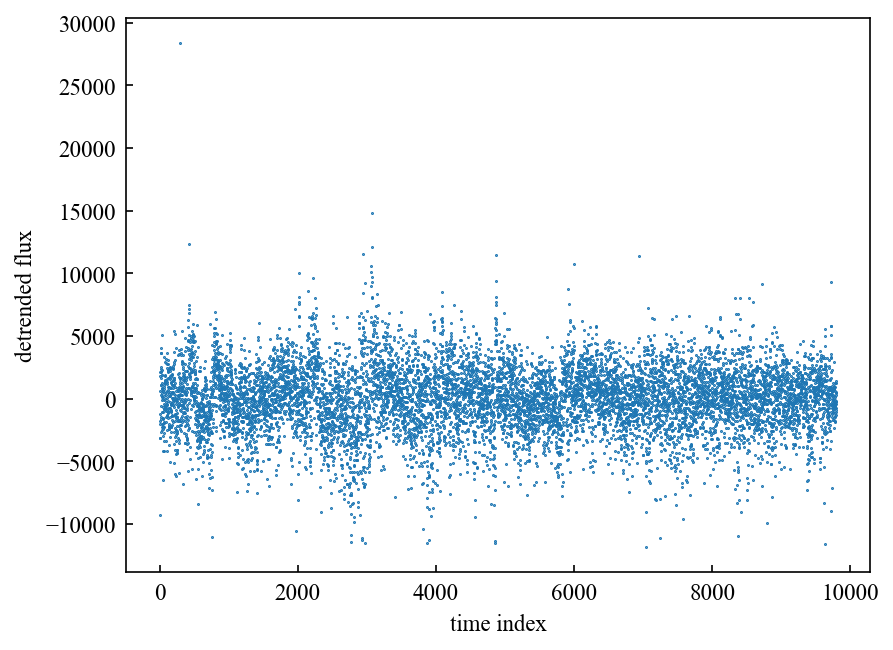

In [7]:
plt.scatter(times[1],lcs[1] - pfit(times[1]), s = 0.2)
plt.xlabel('time index'); plt.ylabel('detrended flux')

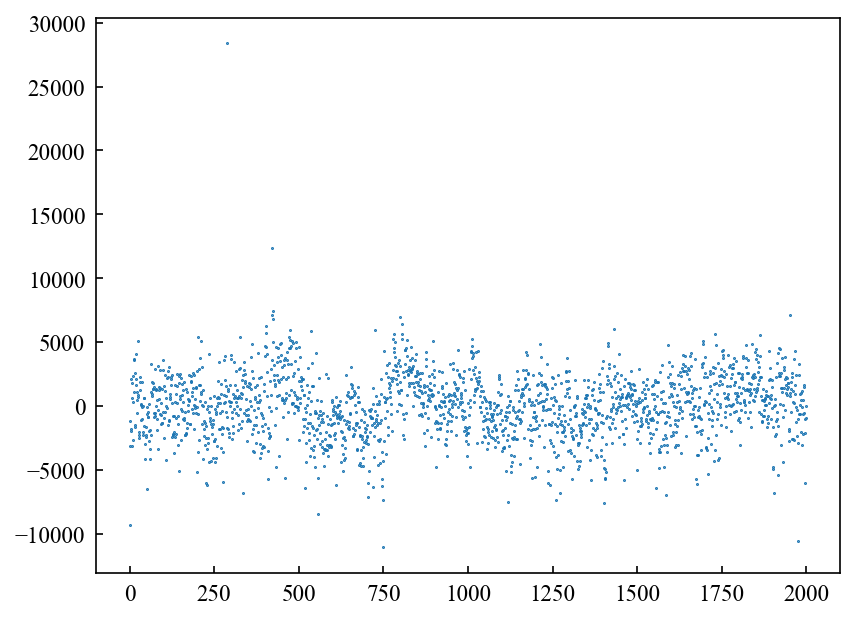

In [8]:
x2000 = x[:2000]
y2000 = y[:2000]

plt.scatter(x2000,y2000 - pfit(x2000), s = 0.2)    

### <font color='blue'>Exercise 2 (8 points): Measuring the mean density of mass in stars in the Universe</font>


In the previous assignment you have estimated the mean density of matter and dark energy in the Universe in the units of critical density of the Universe, $\rho_{\rm crit}=3H_0^2/(8\pi G)\approx 1.3598\times 10^{11}\ M_\odot/\rm Mpc^3$: $\Omega_{\rm m0}\approx 0.26$, $\Omega_\Lambda\approx 0.74$. 

In this exercise you will use the estimate of stellar mass function (SMF) of galaxies to estimate the mean density of stars in units of the critical density. The SMF is the number density of galaxies (number of galaxies per Mpc$^3$). The functions below read a catalog of galaxies (function `read_meert_catalog`) identified in the Sloan Digital Sky Survey (SDSS) and estimate SMF (function `estimate_smf`) in bins of $\log_{10} M_\star$. The latter function returns array of centers of the bins $\log_{10} M_\star$ and SMF as $dn/d\log_{10}M_\star$. 

For convenience let us denote $\mu = \log_{10}M_\star$.

The SMF can be used to estimate the mean number density of mass stars as 
$$\rho_\star = \int\limits_{\mu_{\rm min}}^{\mu_{\rm max}} M_\star \frac{dn}{d\mu}d\mu,$$

where $\mu_{\rm min}$ and $\mu_{\rm max}$ are the centers of the first and last bins of the estimated SMF. 

**Task 2a (3 points).***  Use SciPy's [UnivariateSpline](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.UnivariateSpline.html) to approximate $M_\star \frac{dn}{d\mu}$ (where $M_\star=10^\mu$) as a function of $\mu$. Plot the approximation as a function of $\log_{10} M_\star$ with the linear scale of $y$ axis (that is without `plt.yscale('log')` but with $x$-axis on the log scale (i.e. plot $10^\mu$ and use `plt.xscale('log')`). You should see a sharply peaked curve with the peak indicating the stellar mass of galaxies containing most of the stellar mass (i.e. most of the stars in the Universe). Our Milky Way galaxy has stellar mass of $\approx 6\times 10^{10}\, M_\odot$. Discuss how close to the peak is the Milky Way? Think about what it tell us about why we found ourselves in a galaxy such as the Milky Way and not in a dwarf galaxy or a very massive galaxy and discuss your thoughts briefly. 

**Task 2b (5 points).** Use the integral method of `UnivariateSpline` with the limits set by the first and last elements of array 
`lmsbinc` as integration limits to estimate the integral above. 

Compute and print out the mean density in stars in units of the critical density of the Universe given above: $\Omega_\star = \rho_\star/\rho_{\rm crit}$. Compare the value you get to the total density of matter in the universe $\Omega_{\rm m0}$. Discuss briefly what this indicates about the composition of matter in the Universe. 

In [9]:
import numpy as np

def read_meert_catalog(phot_type=3, 
                       url = r'https://astro.uchicago.edu/~andrey/classes/a211/data/Meert2015_v2/'):
    """Loader for the Meert et al. 2015 catalog of improved photometric measurements
    for galaxies in the SDSS DR7 main galaxy catalog 
    input: phot_type - integer corresponding to the photometry model fit type from the catalog
        1=best fit, 2=deVaucouleurs, 3=Sersic, 4=DeVExp, 5=SerExp
    returns combined structured array with all the data
    """
    from astropy.io import fits


    if (phot_type < 1) or (phot_type > 5):
        raise Exception(f'phot_type = {phot_type}, must be int between 1 and 5')

    # change datadir to the directory where UPenn catalog is located
    datameertnonpar = url + r'UPenn_PhotDec_nonParam_rband.fits'
    datameertnonparg = url + r'UPenn_PhotDec_nonParam_gband.fits'
    datameert = url + r'UPenn_PhotDec_Models_rband.fits'
    datasdss = url + r'UPenn_PhotDec_CAST.fits'
    datasdssmodels = url + r'UPenn_PhotDec_CASTmodels.fits'
    datameertg = url + r'UPenn_PhotDec_Models_gband.fits'
    datameerti = url + r'UPenn_PhotDec_Models_iband.fits'
    datamorph = url + r'UPenn_PhotDec_H2011.fits' # morphology probabilities from Huertas-Company et al. 2011

    # mdata tables: 1=best fit, 2=deVaucouleurs, 3=Sersic, 4=DeVExp, 5=SerExp
    mdata = fits.open(datameert)[phot_type].data
    mdatag = fits.open(datameertg)[phot_type].data
    mdatai = fits.open(datameerti)[phot_type].data
    mnpdata = fits.open(datameertnonpar)[1].data
    mnpdatag = fits.open(datameertnonparg)[1].data
    sdata = fits.open(datasdss)[1].data
    phot_r = fits.open(datasdssmodels)[1].data
    morph = fits.open(datamorph)[1].data

    # eliminate galaxies with bad photometry
    fflag = mdata['finalflag']
    print("%d galaxies in Meert et al. sample initially"%(np.size(fflag)))

    def isset(flag, bit):
        """Return True if the specified bit is set in the given bit mask"""
        return (flag & (1 << bit)) != 0
        
    # use minimal quality cuts and flags recommended by Alan Meert
    igood = ((phot_r['petroMag'] > 0.) & (phot_r['petroMag'] < 100.) & (mnpdata['kcorr'] > 0) &
             (mdata['m_tot'] > 0) & (mdata['m_tot'] < 100) &
             (isset(fflag, 1) | isset(fflag, 4) | isset(fflag, 10) | isset(fflag, 14)))

    sdata = sdata[igood]; phot_r = phot_r[igood]; mdata = mdata[igood]
    mnpdata = mnpdata[igood]; mdatag = mdatag[igood]; 
    mnpdatag = mnpdatag[igood]; morph = morph[igood]
    mdatai = mdatai[igood]
    zm = sdata['z']; mpetrom = phot_r['petroMag']; mmeert = mdata['m_tot']
    extm = mnpdata['extinction']; kcorr = mnpdata['kcorr']
    # correct for extinction, add evolution correction and K-correction
    mr = mmeert - extm + 1.3 * zm - kcorr
    mg = mdatag['m_tot'] - mnpdatag['extinction'] + 1.3 * zm - kcorr
    gr = mg - mr
    isel = (-0.5<gr) & (gr < 2) 
    return zm[isel], mr[isel], gr[isel]


In [10]:
from astropy.cosmology import LambdaCDM
import astropy.units as u

def d_l_astropy(z, H0, Om0, OmL, clight=2.99792e5):
    '''
    compute luminosity distance using AstroPy d_L function
    
    Parameters:
    
    z - float, or numpy array, redshift
    H0 - float, Hubble constant in km/s/Mpc
    Om0, OmL - floats, dimensionless matter and dark energy densities
    
    Returns:
    
        d_L - float, or numpy array, rescaled by c/H0 in Mpc 
    '''
    cosmo = LambdaCDM(H0=H0, Om0=Om0, Ode0=OmL)
    
    return cosmo.luminosity_distance(z=z) / u.Mpc 

In [11]:
def estimate_smf(z, mr, gr, nbins=80, H0=70., Om0=0.26, OmL=0.74):
    """
    Compute stellar mass function of galaxies - the number density of galaxies 
          in Mpc^-3 per decade of log10(Mstar)
          
    Parameters:
        z: array of galaxy redshifts
        mr: array of r-band galaxy apparent magnitudes
        gr: mg - mr, array with differences between g- and r-band magnitudes (g-r color)
        nbins
        
    Returns:
        lmbinc: center of the bin in log10(Mstar)
        dn/dlog10(Mstar) - number density in Mpc^{-3} per unit log10(Mstar)
    """
    d_l = d_l_astropy(z, H0, Om0, OmL)
    # absolute magnitude in the r-band, accounting for extinction, evolution and K-correction
    Mr = mr - 5.0*np.log10(d_l*1e5) 
    # r-band luminosity in Lsun,r from the cmodel and Petrosian absolute mmagnitudes
    Lr =  0.4*(4.67-Mr)
    # conver from log10(r-band luminosity) to mass of stars of each galaxy
    # Bell et al. 2003, ApJS 149, 289 derived from SPS 
    lMLr = -0.306 + 1.097*gr
    lms = Lr + lMLr

    # the sample magnitude limit is defined using Petrosian magnitude, so this is what we need to use to compute Vmax
    # we need to compute at what distance this galaxy would have limiting magnitude mlim, 
    # then compute Vmax using this distance, assuming flat cosmology (not a big deal at these low z): Vmax=d_M^3(z); d_M=d_L/(1+z) 
    m_min, m_max = 14., 17.77
    d_Mmax = 1.e-5*np.power(10., 0.2*(m_max-Mr))/(1.+z)
    d_Mmin = 1.e-5*np.power(10., 0.2*(m_min-Mr))/(1.+z)

    # inverse Vmax comoving volume to be used as weights in distribution histograms
    vmaxi = 1.0/(np.power(d_Mmax,3.0) - np.power(d_Mmin,3.0))

    # SDSS DR8 solid angle in steradians, 
    # the solid angle of the SDSS spectroscopic survey is 9274 square degrees, see:
    # https://www.sdss3.org/dr8/scope.php
    solid_angle = 9274.*(np.pi/180)**2
    solid_angle = 4.*np.pi/3*0.195

    # 0.93 - spectroscopic completeness correction - see Bernardi et al. 2010
    cc = 0.93 
    # final 1/Vmax
    vmaxi = vmaxi / (solid_angle*cc)

    phi, lmbins = np.histogram(lms, weights=vmaxi, bins=nbins)
    lmbinc = 0.5 * (lmbins[1:] + lmbins[:-1])
    dlmbins = lmbins[1:] - lmbins[:-1]
    return lmbinc, phi / dlmbins


In [12]:
# read SDSS galaxy sample
z, mr, gr = read_meert_catalog() 

670722 galaxies in Meert et al. sample initially


In [13]:
# estimate stellar mass function dn/dlog10(Mstar)
# lmsbinc - centers of bins of log10(Mstar)
lmsbinc, dndlogms = estimate_smf(z, mr, gr)
#^^^ --> mu and dn/dmu

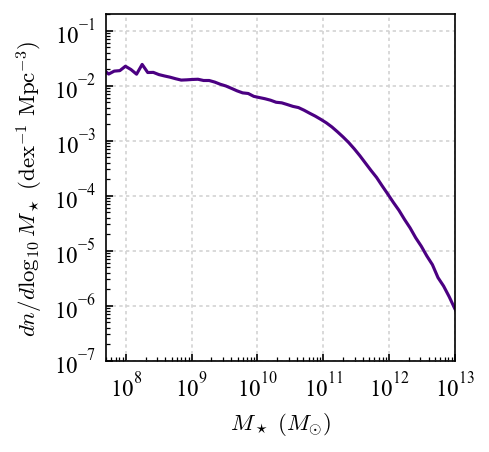

In [14]:
# plot stellar mass function
fig = plt.figure(figsize=(3, 3))

plt.xlabel(r'$M_\star\ (M_{\odot})$')
plt.ylabel(r'$dn/d\log_{10}M_\star\ (\mathrm{dex^{-1}\ Mpc^{-3}})$')
plt.xlim(5.e7, 1e13); 
plt.ylim(1e-7, 0.2)
plt.xscale('log'); plt.yscale('log')

plt.plot(10.**lmsbinc, dndlogms, c='indigo')

plt.grid(ls='dotted', c='lightgray')
plt.show()

Text(0, 0.5, '\\log_{10}{$M_\\star\\} dn/d\\mu$')

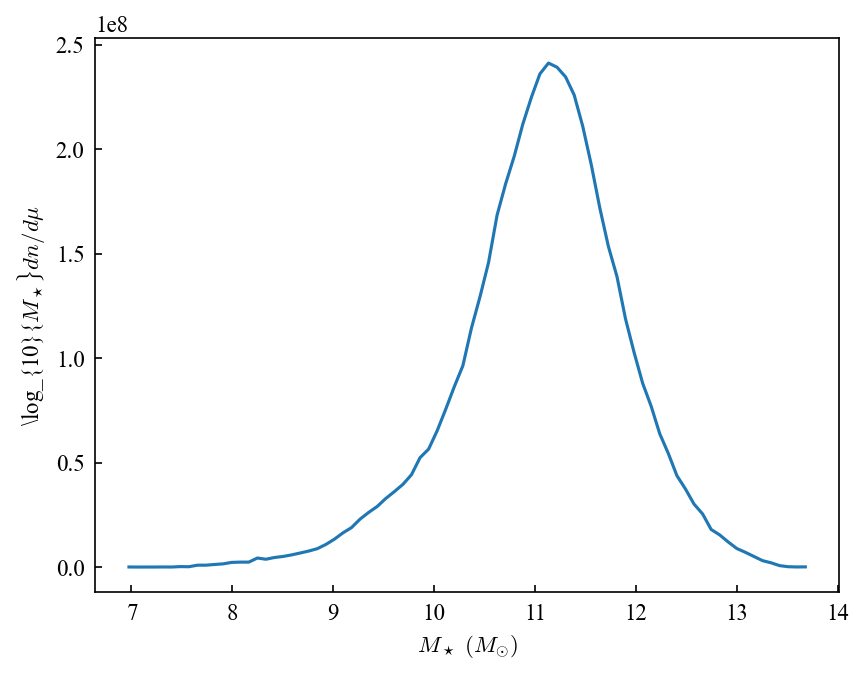

In [15]:
#plt.xscale('log')
plt.plot(lmsbinc,(10.**lmsbinc)*dndlogms)
plt.xlabel(r'$M_\star\ (M_{\odot})$')
plt.ylabel(r'\log_{10}{$M_\star\} dn/d\mu$')

#2b------------------------------------------------------->
#The peak is very close to the mass of the Milky way which means it is among the galaxies that have most of the stars in the universe. 
#With stars comes planets and the potential for life --> it almost serves as an explaination for why we exist. 

### <font color='blue'>Exercise 3: Generating a mock galaxy sample using spline approximation and the ITS method (6 points)</font></font>

In [Section 8.4.3](https://astro.uchicago.edu/~andrey/classes/a211w24/html/func_approx/spline.html#using-spline-approximation-to-invert-functions-and-to-sample-random-numbers) the application of spline approximation for sampling random methods from the pdf is discussed. The idea is to use spline to accurately represent the inverse of the cdf and use it to generate random numbers that follow the pdf corresponding to the cdf. Example of this application to generate mock supernovae type Ia is provided in [07_func_approximation_class](https://drive.google.com/file/d/1OJPfSfpfMlPP5HCdhrihIK02h7T2m3Jc/view?usp=drive_link). 

Splines can also be used to evaluate the integral for the cdf calculation as well. We can see how this method works by using the stellar mass function estimated in ex 2. If we have an estimate of SMF $dn/d\mu$, where as in the ex 2 $\mu=\log_{10} M_\star$, the cdf of $\mu$ is 

$$P(<\mu)=\frac{\int\limits_{\mu_{\rm min}}^{\mu}\frac{dn}{dx}dx}{\int\limits_{\mu_{\rm min}}^{\mu_{\rm max}}\frac{dn}{dx}dx}.$$


The integrals in the equation above can be estimated using spline approximation of $dn/d\mu$ as a function of $\mu$. 

**Task 3a (2 points).** Estimate $P(<\mu)$ using splines.

**Task 3b (2 points).** Use cubic spline to approximate the inverse cdf (i.e. $\mu$ as a function of $P(<\mu)$. Generate a million uniformly distributed random numbers in the range $[0,1]$. Use the inverse transform sampling method to generate million random $\mu=\log_{10}M_\star$ values that follow SMF. 

**Task 3c (2 points)** Plot the histogram of generated $\log_{10}M_\star$ values and check that the distribution follows the spline approximation $dn/d\mu$ used in 3a by overplotting the spline approximation as a line. 
Figure out how to normalize the curves so that they match in amplitude and compare the shape. Correct generation of random numbers should produce histogram that matches the SDSS SMF closely. 

In [16]:
print(lmsbinc.shape)

(80,)


In [17]:
spl = UnivariateSpline(lmsbinc, dndlogms, s = 0.)

cdf = []
for i, m in enumerate(lmsbinc):
    numerator = spl.integral(lmsbinc.min(),lmsbinc[i])
    denominator = spl.integral(lmsbinc.min(),lmsbinc.max())
    c = numerator/denominator
    cdf = np.append(cdf, c)

In [18]:
samp_num = 100000
icdf_spl = UnivariateSpline(cdf, lmsbinc, s = 0.)
u = np.random.uniform(size = 100000)
mu_mock = icdf_spl(u)



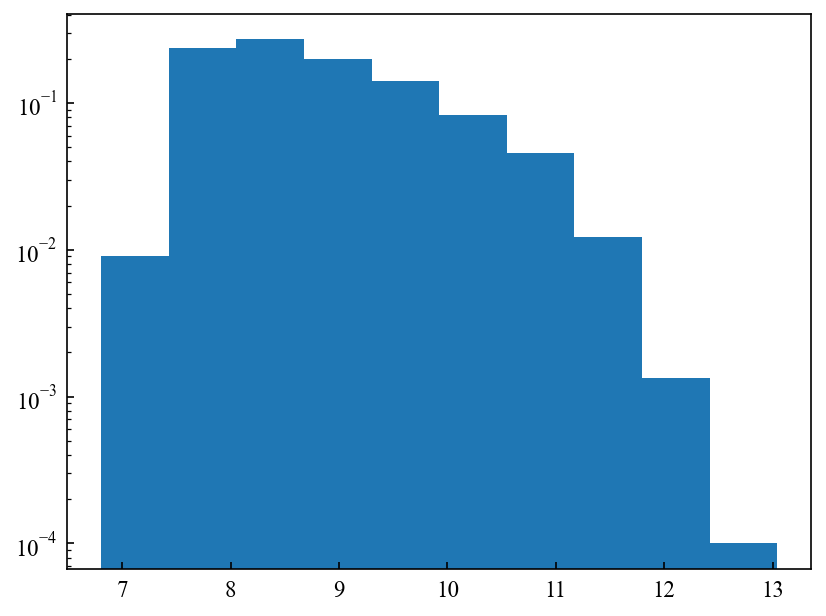

In [19]:
plt.hist(mu_mock, weights = 1/samp_num*np.ones_like(mu_mock))
plt.yscale('log')


In [20]:
phi_mock, lmmbins = np.histogram(mu_mock, bins=40)
# centers of bins
lmmbinc = 0.5 * (lmmbins[1:] + lmmbins[:-1])
# sizes of bins in log10(Mstar) for mock galaxies
dlmmbins = lmmbins[1:] - lmmbins[:-1]
# compute dn/dlog10(Mstar) normalized to total number of galaxies
phi_mock = phi_mock / dlmmbins / mu_mock.size



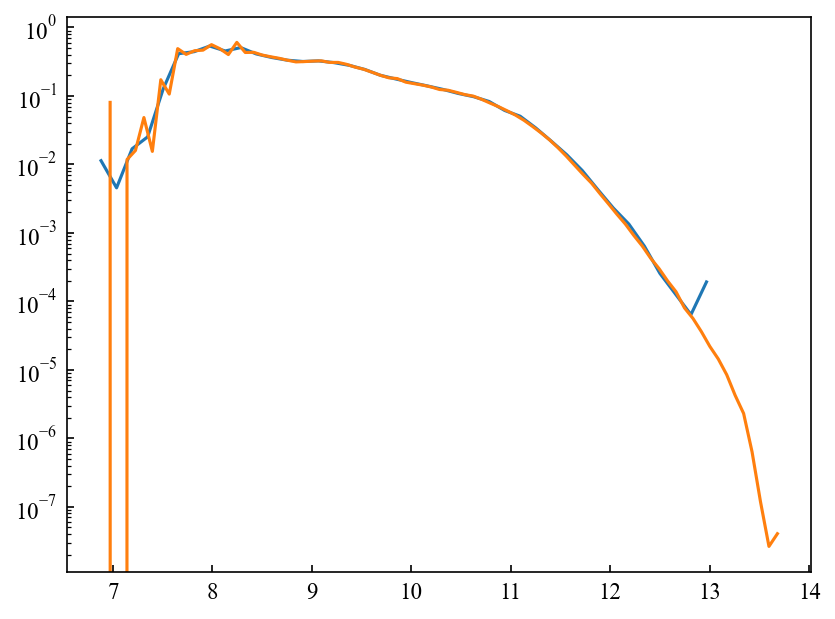

In [22]:
plt.plot(lmmbinc, phi_mock)
plt.yscale('log')
# the normalized dn/dlog10(Mstar) for SDSS galaxies.. 
plt.plot(lmsbinc, dndlogms/spl.integral(lmsbinc[0], lmsbinc[-1]))